In [115]:
import sys
sys.path.append('../lib/BioInfer_software_1.0.1_Python3/')
sys.path.append('../py/')
from BIParser import BIParser
from BasicClasses import RelNode
from classes import BioInferTaskConfiguration

import os
import json
# os.environ['DGL_BACKEND'] = "pytorch" 
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

from collections import Counter, OrderedDict

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
parser = BIParser()

In [4]:
with open('../data/BioInfer_corpus_1.1.1.xml','r') as f:
    parser.parse(f)

In [27]:
from config import ENTITY_PREFIX, PREDICATE_PREFIX

## Extract BioInfer data

In [6]:
def tree_height(children):
    height = max([tree_height(child.arguments) + 1 if child.isPredicate() else 0 for child in children])
    return height

In [7]:
texts = []
BIO_labels = []
tuple_labels = []


sentences = parser.bioinfer.sentences.sentences
for s in sentences:
    tokens = [t.getText() for t in s.tokens]
    
    # initialize Beginning Inside Outside (BIO) encoding for entities, maybe useful if we want to add NER as joint task
    NER_labels = ['O' for t in s.tokens] 
    
    # GET DISJOINT SETS OF NESTED AND TOP-LEVEL ENTITIES
    nested_entities = set()
    for e in s.entities:
        for n in e.nestedEntities:
            nested_entities.add(n)

    top_level_entities = set()
    for e in s.entities:
        if e not in nested_entities:
            top_level_entities.add(e)
    
    #check that sets are disjoint and cover the full set of entities in the sentence
    disjoint = len(nested_entities.intersection(top_level_entities)) == 0
    matching_len = len(nested_entities) + len(top_level_entities) == len(s.entities)
    assert disjoint and matching_len
    
    # CREATE TUPLES OF (<entity_class>, (<entity_token_1>,<entity_token_2>,...)
    # note that this ignores labels starting with "RELATIONSHIP_"
    entity_tuples = []
    
    for e in nested_entities:
        entity_type = e.type.name
        if 'RELATIONSHIP' not in entity_type:
            entity_tuples.append((entity_type,tuple([st.token.sequence for st in e.subTokens])))
            
    for e in top_level_entities:
        entity_type = e.type.name
        if 'RELATIONSHIP' not in entity_type:
            entity_tuples.append((entity_type,tuple([st.token.sequence for st in e.subTokens])))    
    
    # PERFORM BIO ENCODING FOR TOP-LEVEL ENTITIES
    for e in top_level_entities:
        prefix = 'B-'
        entity_type = e.type.name
        if 'RELATIONSHIP' not in entity_type:
            for t in list(OrderedDict.fromkeys([st.token for st in e.subTokens])):
                NER_labels[t.sequence] = prefix + entity_type
                prefix = 'I-'
                
    texts.append(tokens)
    BIO_labels.append(NER_labels)
    tuple_labels.append(entity_tuples)

In [8]:
sentence_stats = pd.DataFrame(columns=['n_entities','n_relations','n_layers'])

for s in sentences:
    n_entities = len(s.entities)
    n_relations = len(s.formulas)
    heights = [tree_height([f.rootNode]) for f in s.formulas]
    if len(heights) > 0:
        n_layers = max(heights)
    else:
        n_layers = 0
    
    sentence_stats = sentence_stats.append(pd.Series([n_entities,n_relations,n_layers],index=sentence_stats.columns),ignore_index=True)

Text(0, 0.5, '')

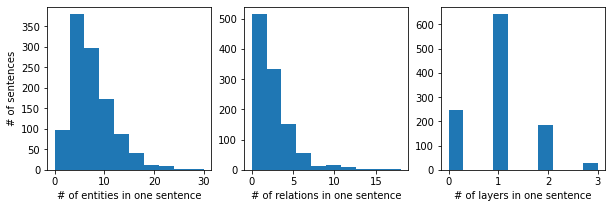

In [9]:
fig, axs = plt.subplots(1,3,figsize=(10,3))

sentence_stats.n_entities.plot.hist(ax=axs[0])
axs[0].set_xlabel('# of entities in one sentence')
sentence_stats.n_relations.plot.hist(ax=axs[1])
axs[1].set_xlabel('# of relations in one sentence')
sentence_stats.n_layers.plot.hist(ax=axs[2])
axs[2].set_xlabel('# of layers in one sentence')
axs[0].set_ylabel('# of sentences')
axs[1].set_ylabel('')
axs[2].set_ylabel('')

In [10]:
len(sentence_stats[sentence_stats['n_layers'] > 1]) / len(sentence_stats)

0.19272727272727272

#### inspect results

In [11]:
texts[0]

['alpha-catenin',
 'inhibits',
 'beta-catenin',
 'signaling',
 'by',
 'preventing',
 'formation',
 'of',
 'a',
 'beta-catenin*T-cell',
 'factor*DNA',
 'complex',
 '.']

In [12]:
tuple_labels[0]

[('Individual_protein', (9, 10)),
 ('Individual_protein', (2,)),
 ('Individual_protein', (9,)),
 ('Individual_protein', (0,)),
 ('Function_property', (2, 3)),
 ('Protein_complex', (9, 9, 9, 10, 10, 11))]

In [13]:
BIO_labels[0]

['B-Individual_protein',
 'O',
 'B-Function_property',
 'I-Function_property',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Protein_complex',
 'I-Protein_complex',
 'I-Protein_complex',
 'O']

In [114]:
with open('../data/')
tuple_labels

[[('Individual_protein', (9, 10)),
  ('Individual_protein', (2,)),
  ('Individual_protein', (9,)),
  ('Individual_protein', (0,)),
  ('Function_property', (2, 3)),
  ('Protein_complex', (9, 9, 9, 10, 10, 11))],
 [('Individual_protein', (5,)),
  ('Individual_protein', (7, 8, 9)),
  ('Individual_protein', (4, 5)),
  ('Protein_complex', (2, 3, 4, 5, 6, 7, 8, 9))],
 [('Gene/protein/RNA', (25,)),
  ('Gene/protein/RNA', (16,)),
  ('Gene/protein/RNA', (44,)),
  ('Gene/protein/RNA', (34,))],
 [('Individual_protein', (11,)),
  ('Individual_protein', (2,)),
  ('Cell_component', (8, 9, 10, 11)),
  ('Amount_property', (0, 1, 2))],
 [('Individual_protein', (4,)),
  ('Individual_protein', (13,)),
  ('Individual_protein', (9, 10, 11)),
  ('Individual_protein', (6, 7, 11)),
  ('Individual_protein', (19,)),
  ('Individual_protein', (26,)),
  ('Individual_protein', (2,)),
  ('Amount_property', (0, 1, 9, 10, 11)),
  ('Amount_property', (0, 1, 19)),
  ('Expression', (26, 27)),
  ('Amount_property', (0, 1,

## Extract BioInfer metadata

Get BioInfer task configuration

In [94]:
config = BioInferTaskConfiguration().from_parser(parser)

In [95]:
schema = config.schema

In [96]:
config.to_json('../data/configuration.json')

In [97]:
from collections import namedtuple

In [ ]:
namedtuple

In [112]:
Element = namedtuple('Element', ['name','hidden_vector'])

In [113]:
Element

__main__.Element

In [109]:
e = Element('p-Something',[0.1,0.2,0.3])

In [110]:
e.hidden_vector

[0.1, 0.2, 0.3]

In [111]:
class ElementList():
    def __init__(self,):
        self.elements = {}
    
    def add_element(self,element):
        self.elements[(len(self.elements),element.name)] = element.hidden_vector

In [28]:
# configuration = {}

# for s in parser.bioinfer.sentences.sentences:
#     for f in s.formulas:
#         if f.rootNode.isPredicate():
#             predicate_name = f.rootNode.predicate.name
#             if predicate_name not in configuration.keys():
#                 configuration[predicate_name] = Counter()
#             arguments = ','.join(get_relnode_argument_types(f.rootNode))
#             configuration[predicate_name][arguments] += 1
#         elif f.rootNode.isEntity():
#             print(f)

In [29]:
# def get_relnode_argument_types(relnode):
#     arguments = set()
#     for a in relnode.arguments:
#         if a.isEntity():
#             arguments.add(f"{ENTITY_PREFIX}{a.entity.type.name}")
#         elif a.isPredicate():
#             arguments.add(f"{PREDICATE_PREFIX}{a.predicate.name}")
#         else:
#             raise ValueError
        
#     return tuple(sorted(list(arguments)))

In [21]:
# entities = set() 
# for rel, argsets in configuration.items():
#     for argset in argsets:
#         for arg in argset.split(','):
#             if ENTITY_PREFIX in arg:
#                 entities.add(arg.replace(ENTITY_PREFIX,''))
# entities = list(entities)

# entities_to_idx = {entities[i]:i for i in range(len(entities))}

In [22]:
# len(entities)

57

Get BioInfer relation-to-index lookup dict

In [83]:
# elements = sorted(relations) + sorted(entities)

## Figures

In [27]:
config_df = pd.DataFrame(configuration)

How many relations in the data?

In [28]:
config_df.sum().sum()

2550.0

In [62]:
config_df_gt_1 = config_df[(config_df.fillna(0).sum(axis = 1) > 2)]

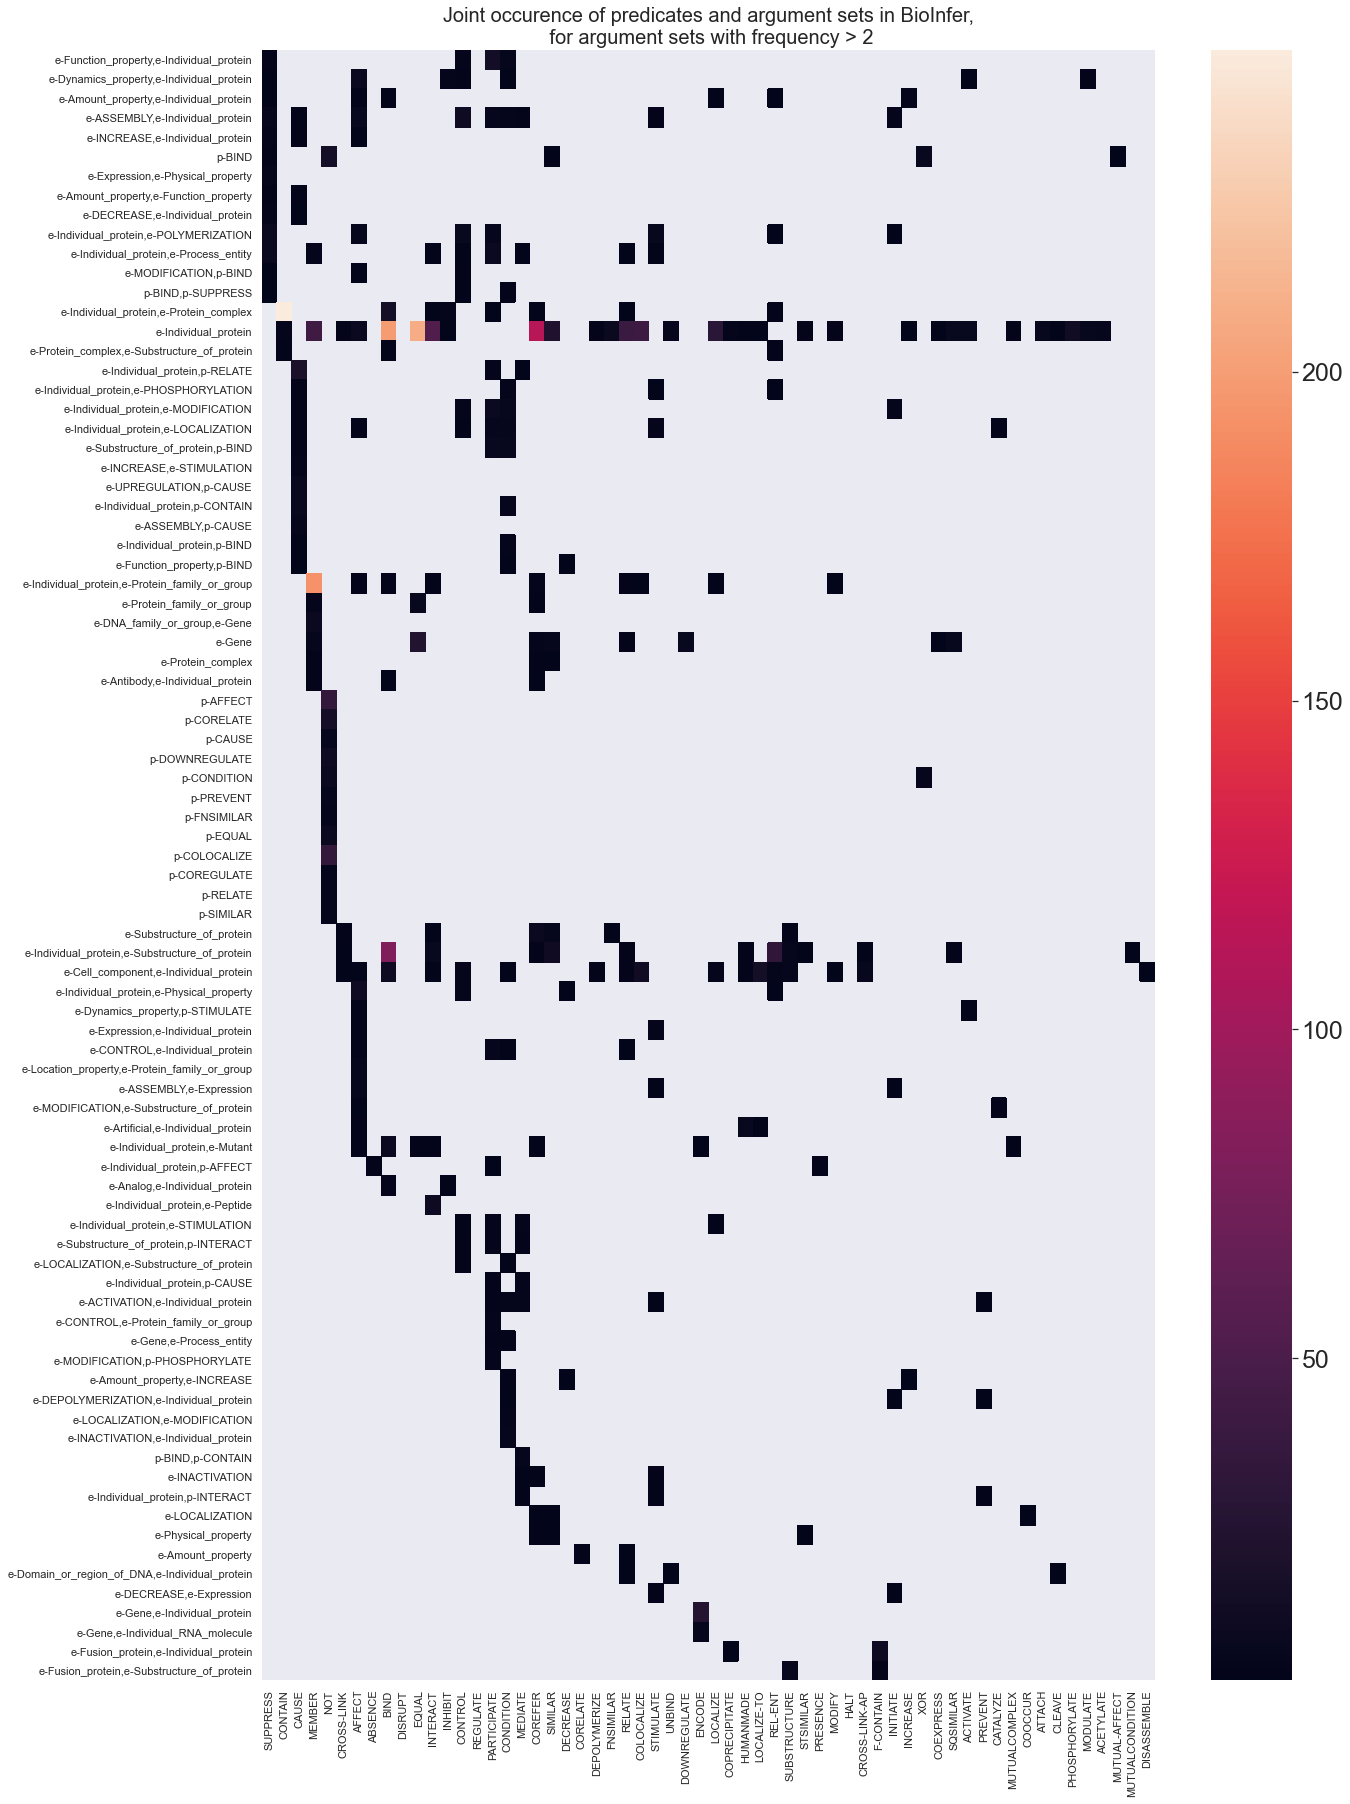

In [78]:
fig, axs = plt.subplots(1,figsize=(20,30))
ax = sns.heatmap(config_df_gt_1,ax=axs,yticklabels=True,xticklabels=True)
# ax.tick_params(labelsize=5)
axs.set_title("Joint occurence of predicates and argument sets in BioInfer,\n for argument sets with frequency > 2",fontsize=20)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=25)
axs.figure.savefig('../reports/heatmap.png')

How many relation predicates?

In [214]:
len(relation_types)

60

In [ ]:
relation_types = config_df.sum().sort_values(ascending=False)

relation_types.sum() * 0.9


relation_types.head(10).sum() / relation_types.sum()

relation_types

<AxesSubplot:>

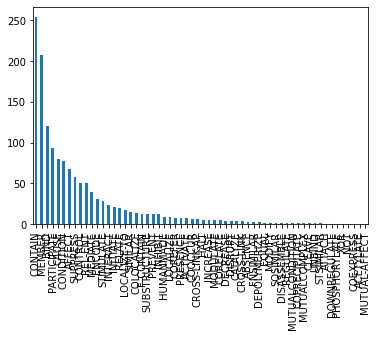

In [89]:
relation_types.plot.bar()